Dataset: https://www.kaggle.com/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset

In [33]:
! pip install -q kaggle

In [34]:
from google.colab import files

In [35]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"sarahnajibah","key":"a0c6584f4b7f78a42496f97d6e6aede6"}'}

In [36]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [37]:
! cp kaggle.json ~/.kaggle/

In [38]:
! chmod 600 ~/.kaggle/kaggle.json

In [39]:
!kaggle datasets list -s lung-cancer

ref                                                        title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
mysarahmadbhat/lung-cancer                                 Lung Cancer                                        2KB  2021-10-01 13:39:48          10782        150  1.0              
nancyalaswad90/lung-cancer                                 Lung Cancer                                        2KB  2022-07-15 19:23:28           2378         94  1.0              
jillanisofttech/lung-cancer-detection                      Lung Cancer Detection                              2KB  2022-07-22 16:18:58           1183         43  0.9705882        
yusufdede/lung-cancer-dataset                              Lung Cancer DataSet                      

In [40]:
!kaggle datasets download -d hamdallak/the-iqothnccd-lung-cancer-dataset 

 83% 124M/149M [00:00<00:00, 280MB/s] 
100% 149M/149M [00:00<00:00, 264MB/s]


In [41]:
import zipfile
import os

Extract Dataset

In [42]:
! unzip \*.zip && rm *.zip

Archive:  the-iqothnccd-lung-cancer-dataset.zip
replace The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
  inflating: The IQ-OTHNCCD lung cancer dataset/IQ-OTH_NCCD lung cancer dataset.txt  


In [43]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np 
import pandas as pd
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [44]:
import os
import PIL
import pathlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [45]:
BATCH_SIZE = 62 #jumlah training sample per iterasi
IMAGE_SIZE = 256
CHANNELS=3

Preprocessing

In [46]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/The IQ-OTHNCCD lung cancer dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1097 files belonging to 4 classes.


In [47]:
class_names = dataset.class_names
class_names

['.ipynb_checkpoints', 'Bengin cases', 'Malignant cases', 'Normal cases']

In [48]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [49]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [50]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [51]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

Build Model

In [52]:
n_classes=9
model = models.Sequential([resize_and_rescale,])

model.add(Conv2D(filters= 16, kernel_size= (3,3), activation= 'relu', input_shape= (256,256,3)))

model.add(Conv2D(filters= 32, kernel_size= (3,3), activation= 'relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters= 64, kernel_size= (3,3), activation= 'relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters= 128, kernel_size= (3,3), activation= 'relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate= 0.25))

model.add(Flatten())
model.add(Dense(units=64, activation= 'relu'))
model.add(Dropout(rate= 0.25))
model.add(Dense(n_classes, activation='softmax'))
model.build((62,256,256,3))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (62, 256, 256, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (62, 254, 254, 16)        448       
                                                                 
 conv2d_5 (Conv2D)           (62, 252, 252, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (62, 126, 126, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (62, 124, 124, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                  

In [53]:
#finalisasi
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Train Model

In [54]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
14/14 [==============================] - 117s 8s/step - loss: 1.2567 - accuracy: 0.4547 - val_loss: 0.8678 - val_accuracy: 0.5645
Epoch 2/5
14/14 [==============================] - 107s 8s/step - loss: 0.8061 - accuracy: 0.6478 - val_loss: 0.5235 - val_accuracy: 0.7903
Epoch 3/5
14/14 [==============================] - 110s 8s/step - loss: 0.4532 - accuracy: 0.8339 - val_loss: 0.2054 - val_accuracy: 0.9355
Epoch 4/5
14/14 [==============================] - 108s 8s/step - loss: 0.1833 - accuracy: 0.9329 - val_loss: 0.0615 - val_accuracy: 0.9839
Epoch 5/5
14/14 [==============================] - 107s 8s/step - loss: 0.1070 - accuracy: 0.9623 - val_loss: 0.0745 - val_accuracy: 0.9677


In [55]:
model.evaluate(test_ds)

3/3 [==============================] - 9s 2s/step - loss: 0.0688 - accuracy: 0.9731


[0.06882286071777344, 0.9731183052062988]

In [56]:
acc = history.history['accuracy']
loss = history.history['loss']

In [57]:
print(acc)

[0.4546525180339813, 0.6478209495544434, 0.833922266960144, 0.9328621625900269, 0.9623085856437683]


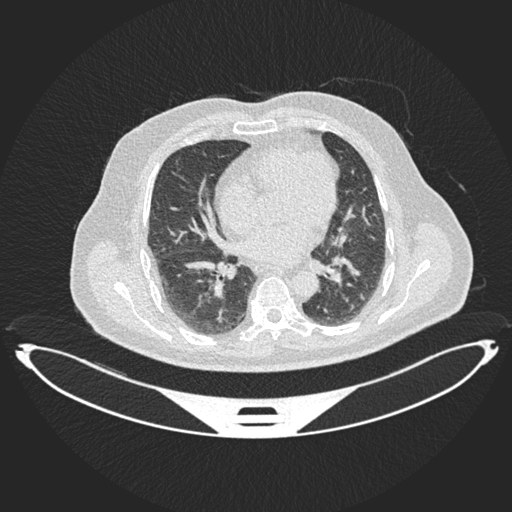

In [58]:
image_path = "/content/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (1).jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
new_img= scaled_img.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)

image

In [59]:
pred = model.predict(scaled_img)
print(pred)

[[4.1483181e-09 9.9888772e-01 3.5339131e-04 7.5822516e-04 3.6191045e-07
  1.8675001e-07 3.6522110e-08 2.3490754e-08 6.9063018e-09]]


In [60]:
output = class_names[np.argmax(pred)]
output

'Bengin cases'

In [61]:
h= history.history

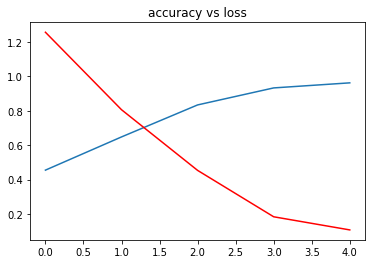

In [62]:
plt.plot(h['accuracy'])
plt.plot(h['loss'], c= "red")

plt.title("accuracy vs loss")
plt.show()